## Importing libraries


In [8]:
import gc  # garbage collector
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pylab

pd.set_option("display.max_columns", None)

import warnings

warnings.filterwarnings("ignore")

from helper import utility as ut
import importlib

importlib.reload(ut)

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

## Load Dataset - Common for both Models


In [14]:
prop_2016 = ut.load_properties_data("clean_data/prop_2016_clean.csv")
prop_2017 = ut.load_properties_data("clean_data/prop_2017_clean.csv")
train = ut.load_properties_data("clean_data/train_combined.csv")

train.dtypes

parcelid                       int64
logerror                     float64
airconditioningtypeid          int64
architecturalstyletypeid       int64
basementsqft                 float64
                              ...   
avg_area_per_room            float64
derived_avg_area_per_room    float64
year                           int64
month                          int64
quarter                        int64
Length: 71, dtype: object

## Catboost Model


In [15]:
# Dropping columns which do not perform well when we input to the catboost model
catboost_features = ut.drop_features(train)
print("Number of features for CatBoost: {}".format(len(catboost_features.columns)))
catboost_features.head(5)

# Prepare feature list for catboost model
categorical_features = [
    "airconditioningtypeid",
    "heatingorsystemtypeid",
    "propertylandusetypeid",
    "year",
    "month",
    "quarter",
    "buildingclasstypeid",
]
for col in catboost_features.columns:
    if col in categorical_features:
        catboost_features[col] = catboost_features[col].astype("str")

Number of features for CatBoost: 55


In [16]:
# Prepare training and cross-validation data
catboost_label = train.logerror.astype(np.float32)
print(catboost_label.head())

# Transform to Numpy matrices
catboost_X = catboost_features.values
catboost_y = catboost_label.values

# Perform shuffled train/test split
X_train, X_val, y_train, y_val = train_test_split(
    catboost_X, catboost_y, test_size=0.2, random_state=99
)
ut.remove_outliers(X_train, y_train)

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
new_X: (131462, 55)
new_y: (131462,)


(array([['-1', 2.5, 3.0, ..., '0', '5', '2'],
        ['0', 2.0, 4.0, ..., '1', '6', '2'],
        ['0', 3.0, 4.0, ..., '0', '8', '3'],
        ...,
        ['-1', 3.0, 4.0, ..., '1', '9', '3'],
        ['-1', 2.5, 3.0, ..., '0', '4', '2'],
        ['0', 2.0, 4.0, ..., '1', '8', '3']], dtype=object),
 array([-0.001     , -0.02973739,  0.0315    , ..., -0.00443901,
         0.007     ,  0.02685545], dtype=float32))

In [17]:
# Specify feature names and categorical features for CatBoost
categorical_indices = ut.get_categorical_indices(
    catboost_features, categorical_features
)

[0, 13, 21, 52, 53, 54]


In [18]:
ut.remove_outliers(catboost_X, catboost_y)

model = CatBoostRegressor(
    loss_function="MAE",
    eval_metric="MAE",
    nan_mode="Min",
    random_seed=99,
    iterations=1000,
    learning_rate=0.015,
    border_count=254,
    max_depth=6,
    random_strength=1,
    l2_leaf_reg=5,
    bagging_temperature=1,
    verbose=True,
)
model.fit(catboost_X, catboost_y, cat_features=categorical_indices, verbose=False)

# Sanity check: score on a small portion of the dataset
print("sanity check score: {}".format(abs(model.predict(X_val) - y_val).mean()))

new_X: (164299, 55)
new_y: (164299,)
sanity check score: 0.06857669115730533


In [20]:
file_name = "submission/final_catboost_single.csv"
submission, pred_2016, pred_2017 = ut.predict_and_generate_csv(
    [model], prop_2016, prop_2017, file_name
)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0130 -0.0130 -0.0130 -0.0159 -0.0159 -0.0159
1  10759547 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121
2  10843547  0.0040  0.0040  0.0040  0.0075  0.0075  0.0075
3  10859147  0.0277  0.0277  0.0277  0.0293  0.0293  0.0293
4  10879947  0.0105  0.0105  0.0105  0.0100  0.0100  0.0100


### Catboost with 4x ensemble


In [21]:
# Train multiple models
rounds = 8
models = []
for i in range(rounds):
    print("Start training model {}".format(i))
    model = CatBoostRegressor(
        loss_function="MAE",
        eval_metric="MAE",
        nan_mode="Min",
        random_seed=99,
        iterations=1000,
        learning_rate=0.015,
        border_count=254,
        max_depth=6,
        random_strength=1,
        l2_leaf_reg=5,
        bagging_temperature=1,
        verbose=True,
    )
    model.fit(catboost_X, catboost_y, cat_features=categorical_indices, verbose=True)
    models.append(model)

Start training model 0
0:	learn: 0.0688501	total: 188ms	remaining: 3m 7s
1:	learn: 0.0688426	total: 286ms	remaining: 2m 22s
2:	learn: 0.0688354	total: 358ms	remaining: 1m 58s
3:	learn: 0.0688278	total: 416ms	remaining: 1m 43s
4:	learn: 0.0688196	total: 467ms	remaining: 1m 33s
5:	learn: 0.0688108	total: 533ms	remaining: 1m 28s
6:	learn: 0.0688048	total: 593ms	remaining: 1m 24s
7:	learn: 0.0687976	total: 638ms	remaining: 1m 19s
8:	learn: 0.0687910	total: 682ms	remaining: 1m 15s
9:	learn: 0.0687832	total: 732ms	remaining: 1m 12s
10:	learn: 0.0687755	total: 782ms	remaining: 1m 10s
11:	learn: 0.0687703	total: 830ms	remaining: 1m 8s
12:	learn: 0.0687629	total: 872ms	remaining: 1m 6s
13:	learn: 0.0687561	total: 919ms	remaining: 1m 4s
14:	learn: 0.0687495	total: 969ms	remaining: 1m 3s
15:	learn: 0.0687423	total: 1.01s	remaining: 1m 2s
16:	learn: 0.0687360	total: 1.06s	remaining: 1m 1s
17:	learn: 0.0687310	total: 1.11s	remaining: 1m
18:	learn: 0.0687249	total: 1.17s	remaining: 1m
19:	learn: 0.0

In [22]:
# Make predictions and export results
file_name = 'submission/final_catboost_ensemble_x4.csv'
submission, pred_2016, pred_2017 = ut.predict_and_generate_csv(models, prop_2016, prop_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Start model 1 (2016)
Start model 1 (2017)
Start model 2 (2016)
Start model 2 (2017)
Start model 3 (2016)
Start model 3 (2017)
Start model 4 (2016)
Start model 4 (2017)
Start model 5 (2016)
Start model 5 (2017)
Start model 6 (2016)
Start model 6 (2017)
Start model 7 (2016)
Start model 7 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0130 -0.0130 -0.0130 -0.0159 -0.0159 -0.0159
1  10759547 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121
2  10843547  0.0040  0.0040  0.0040  0.0075  0.0075  0.0075
3  10859147  0.0277  0.0277  0.0277  0.0293  0.0293  0.0293
4  10879947  0.0105  0.0105  0.0105  0.0100  0.0100  0.0100


## Lightgbm Model


In [23]:
#Drop not useful columns
lightgbm_features = ut.drop_features(train)
print("Number of features for Lightgbm: {}".format(len(lightgbm_features.columns)))
lightgbm_features.head(5)

Number of features for Lightgbm: 55


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet50,finishedsquarefeet6,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,avg_garage_size,property_tax_per_sqft,coord_1,coord_2,coord_3,coord_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,total_room_cnt,avg_area_per_room,derived_avg_area_per_room,year,month,quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769540.0,4658858.0,63903130.0,0.0,1.0,0.0,5.0,NaN,336.80000,0,1,1
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677550.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN,234.0,4.486531,-84009430.0,151345660.0,4248732.0,63087508.0,0.0,1.0,0.0,7.5,NaN,301.73334,0,1,1
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136310.0,-118175030.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311340.0,4592554.0,63680070.0,0.0,1.0,0.0,5.0,NaN,443.40000,0,1,1
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,4178550.0,63333050.0,0.0,1.0,0.0,4.0,NaN,209.75000,0,1,1
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700230.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,299.0,2.404275,-84214590.0,151185870.0,4060586.0,62910704.0,0.0,1.0,0.0,6.5,285.375,351.23077,0,1,1


In [24]:
# Prepare training and cross-validation data
lightgbm_label = train.logerror.astype(np.float32)
print(lightgbm_label.head())

# Transform to Numpy matrices
lightgbm_X = lightgbm_features.values
lightgbm_y = lightgbm_label.values

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lightgbm_X, lightgbm_y, test_size=0.2 , random_state=99)

a,b=ut.remove_outliers(X_train, y_train)
X_train=a
y_train=b

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
new_X: (131462, 55)
new_y: (131462,)
X_train shape: (131462, 55)
y_train shape: (131462,)
X_val shape: (33578, 55)
y_val shape: (33578,)


In [26]:
# Specify feature names and categorical features for Lightgbm
categorical_features = ['airconditioningtypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'year', 'month', 'quarter','buildingclasstypeid']
categorical_indices = ut.get_categorical_indices(lightgbm_features, categorical_features)

[0, 13, 21, 52, 53, 54]


In [27]:
# Lightgbm parameters
params = {}

params["objective"] = "regression"
params["metric"] = "mae"
params["num_threads"] = 4  # set to number of real CPU cores for best performance

params["boosting_type"] = "gbdt"
params["num_boost_round"] = 1250
params["learning_rate"] = 0.003  # shrinkage_rate 
# params["early_stopping_rounds"] = 30  # Early stopping based on validation set performance 

# Control tree growing
params["num_leaves"] = 127  # max number of leaves in one tree (default 31)
params["min_data"] = 150  # min_data_in_leaf
params["min_hessian"] = 0.001  # min_sum_hessian_in_leaf (default 1e-3)
params["max_depth"] = -1  # limit the max depth of tree model, defult -1 (no limit)
params[
    "max_bin"
] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params[
    "sub_feature"
] = 0.5  # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params["bagging_fraction"] = 0.7
params["bagging_freq"] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params[
    "min_data_per_group"
] = 100  # minimal number of data per categorical group (default 100)
params[
    "cat_smooth"
] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params["lambda_l1"] = 0.0
params["lambda_l2"] = 0.0

# Random seeds (keep default values)
params["feature_fraction_seed"] = 2
params["bagging_seed"] = 3

### Lightgbm Single Model


In [28]:
#Train Lightgbm
feature_names = [s for s in lightgbm_features.columns]
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on train and validation sets
print("Train score: {}".format(abs(model.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7058
[LightGBM] [Info] Number of data points in the train set: 131462, number of used features: 55
[LightGBM] [Info] Start training from score 0.007717
Train score: 5.046391194517095
Val score: 6.891320836957143


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

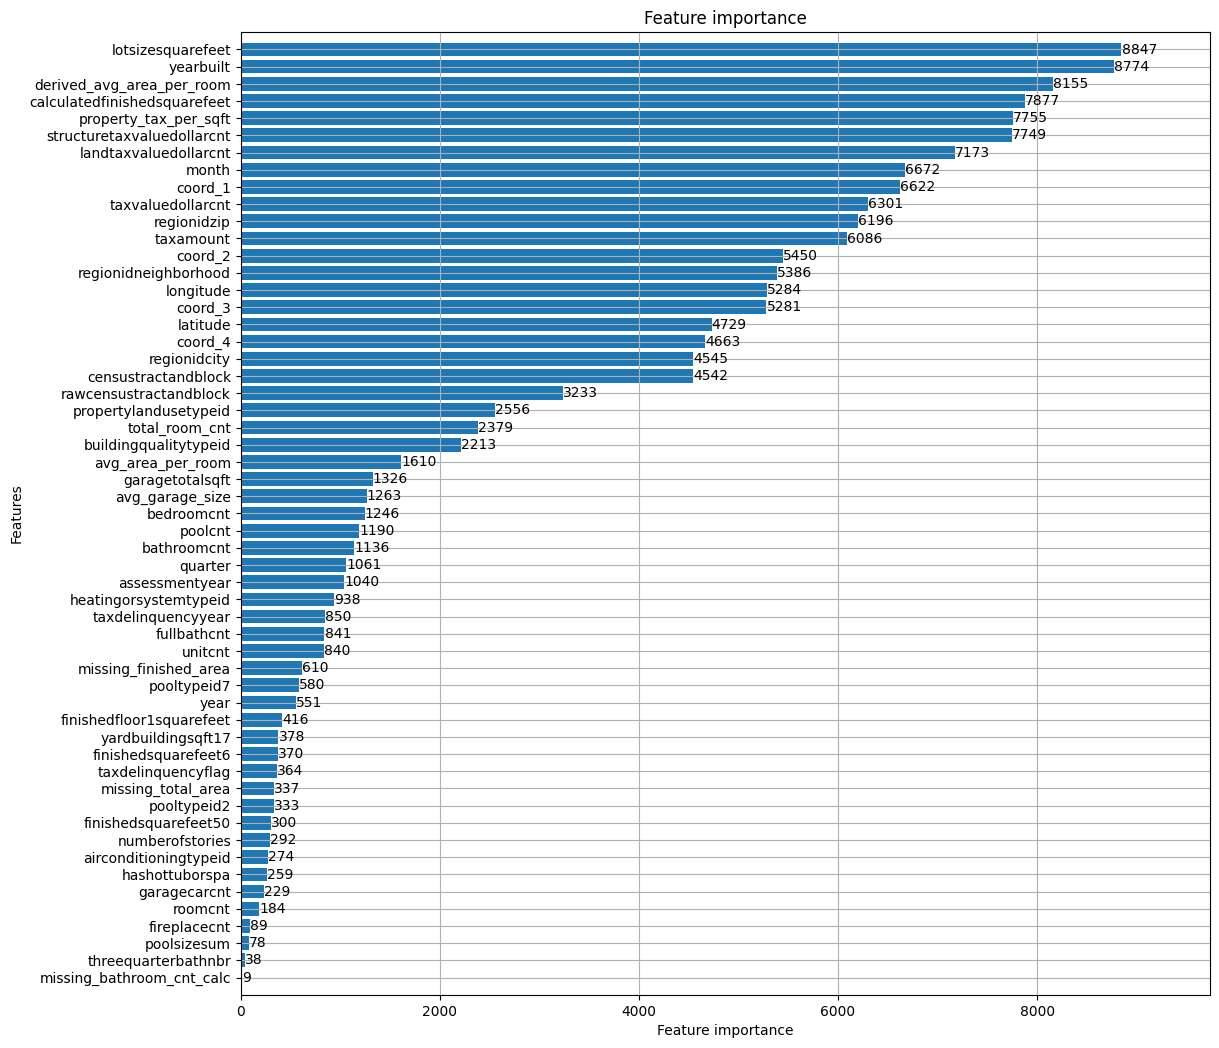

In [29]:
# Plot LightGBM feature importance
lgb.plot_importance(model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [30]:
# Train LightGBM on all given training data (preparing for submission)
#del params['early_stopping_rounds']

a,b=ut.remove_outliers(lightgbm_X,lightgbm_y)
lightgbm_X=a
lightgbm_y=b

lgb_train_set = lgb.Dataset(lightgbm_X, label=lightgbm_y, feature_name=feature_names)
print("lightgbm_X: {}".format(lightgbm_X.shape))
print("lightgbm_y: {}".format(lightgbm_y.shape))

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set, categorical_feature=categorical_indices)

# Sanity check: make sure the model score is reasonable on a small portion of the data
print("score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

new_X: (164299, 55)
new_y: (164299,)
lightgbm_X: (164299, 55)
lightgbm_y: (164299,)
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7132
[LightGBM] [Info] Number of data points in the train set: 164299, number of used features: 55
[LightGBM] [Info] Start training from score 0.007873
score: 6.782186826590446


In [31]:
file_name = 'submission/final_lgb_single.csv'
submission, pred_2016, pred_2017 = ut.predict_and_generate_csv([model], prop_2016, prop_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0213 -0.0213 -0.0213 -0.0174 -0.0174 -0.0174
1  10759547 -0.0162 -0.0162 -0.0162 -0.0147 -0.0147 -0.0147
2  10843547  0.0140  0.0140  0.0140  0.0232  0.0232  0.0232
3  10859147  0.0256  0.0256  0.0256  0.0248  0.0248  0.0248
4  10879947 -0.0018 -0.0018 -0.0018 -0.0016 -0.0016 -0.0016


### Lightgbm Ensemble 5x Model


In [ ]:
a,b=ut.remove_outliers(lightgbm_X,lightgbm_y)
lightgbm_X=a
lightgbm_y=b

lgb_train_set = lgb.Dataset(lightgbm_X, label=lightgbm_y, feature_name=feature_names)

# Train multiple models
bags = 5
models = []
for i in range(bags):
    print("Start training model {}".format(i))
    params["seed"] = i
    np.random.seed(42)
    random.seed(36)
    model = lgb.train(params, lgb_train_set, categorical_feature=categorical_indices)
    models.append(model)

# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_val) - y_val).mean() * 100))

# Save the trained models to disk
ut.save_models(models,'lightgbm')

models = ut.load_lightgbm_models(['checkpoints/lightgbm_' + str(i) for i in range(bags)])  # load pretrained models 

In [ ]:
# Make predictions and export results
file_name = 'submission/final_lgb_ensemble_x5.csv'
submission, pred_2016, pred_2017 = ut.predict_and_generate_csv(models, prop_2016, prop_2017, file_name)

## Stacking


In [32]:
lgb_single = pd.read_csv('submission/final_lgb_single.csv')
catboost_single = pd.read_csv('submission/final_catboost_single.csv')
print("Finished Loading the prediction results.")

def decimal_range(start, stop, increment):
    while start <= stop: 
        yield start
        start += increment

for weight in decimal_range(0.1, 0.9, 0.1):
    #weight = 0.7
    stack = pd.DataFrame()
    stack["ParcelId"] = lgb_single["ParcelId"]
    for col in ["201610", "201611", "201612", "201710", "201711", "201712"]:
        stack[col] = weight * catboost_single[col] + (1 - weight) * lgb_single[col]

    print(stack.head())
    #stack.to_csv("submission/final_stack.csv", index=False)
    stack.to_csv("submission/final_stack_catboostweight_" + str("{:.1f}".format(weight)) + ".csv", index=False)

Finished Loading the prediction results.
   ParcelId   201610   201611   201612   201710   201711   201712
0  10754147 -0.02047 -0.02047 -0.02047 -0.01725 -0.01725 -0.01725
1  10759547 -0.01579 -0.01579 -0.01579 -0.01444 -0.01444 -0.01444
2  10843547  0.01300  0.01300  0.01300  0.02163  0.02163  0.02163
3  10859147  0.02581  0.02581  0.02581  0.02525  0.02525  0.02525
4  10879947 -0.00057 -0.00057 -0.00057 -0.00044 -0.00044 -0.00044
   ParcelId   201610   201611   201612   201710   201711   201712
0  10754147 -0.01964 -0.01964 -0.01964 -0.01710 -0.01710 -0.01710
1  10759547 -0.01538 -0.01538 -0.01538 -0.01418 -0.01418 -0.01418
2  10843547  0.01200  0.01200  0.01200  0.02006  0.02006  0.02006
3  10859147  0.02602  0.02602  0.02602  0.02570  0.02570  0.02570
4  10879947  0.00066  0.00066  0.00066  0.00072  0.00072  0.00072
   ParcelId   201610   201611   201612   201710   201711   201712
0  10754147 -0.01881 -0.01881 -0.01881 -0.01695 -0.01695 -0.01695
1  10759547 -0.01497 -0.01497 -0.01

### XGBoost


In [34]:
import numpy as np
import pandas as pd
import xgboost as xgb
import gc


In [113]:
xgboost_features = ut.drop_features(train)
print("Number of features for Xgboost: {}".format(len(xgboost_features.columns)))
xgboost_features.head(5)
xgboost_features = xgboost_features.fillna(xgboost_features.mean())
xgboost_features.replace([np.inf, -np.inf], 0, inplace=True)
xgboost_features

Number of features for Xgboost: 55


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet50,finishedsquarefeet6,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,avg_garage_size,property_tax_per_sqft,coord_1,coord_2,coord_3,coord_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,total_room_cnt,avg_area_per_room,derived_avg_area_per_room,year,month,quarter
0,0,2.0,3.0,4.000000,1356.491895,1684.0,1367.647018,2197.294919,1.189428,2.0,1.813513,347.603909,1.0,1,34280990.0,-118488536.0,7528.0,1.0,518.930903,1.0,1.0,230,60371068.0,12447.0,31817.000000,96370.0,0.0,1.009134,1.000000,307.919032,1959.0,1.437764,122754.0,360170.0,2015.0,237416.0,6735.88,1.0,13.827247,6.037107e+13,0.0,3.999929,-84207544.0,152769540.0,4658858.0,63903130.0,0.0,1.0,0.0,5.0,274.352519,336.80000,0,1,1
1,-1,3.5,4.0,6.015461,1356.491895,2263.0,1367.647018,2197.294919,1.189428,3.0,2.000000,468.000000,1.0,-1,33668120.0,-117677550.0,3643.0,1.0,518.930903,1.0,1.0,230,60590524.0,32380.0,189295.685382,96962.0,0.0,1.000000,1.110365,307.919032,2014.0,1.437764,346458.0,585529.0,2015.0,239071.0,10153.02,1.0,13.827247,6.049390e+13,234.0,4.486531,-84009430.0,151345660.0,4248732.0,63087508.0,0.0,1.0,0.0,7.5,274.352519,301.73334,0,1,1
2,0,3.0,2.0,4.000000,1356.491895,2217.0,1367.647018,2197.294919,1.189428,3.0,1.813513,347.603909,1.0,1,34136310.0,-118175030.0,11423.0,1.0,518.930903,1.0,1.0,230,60374640.0,47019.0,275411.000000,96293.0,0.0,1.009134,1.000000,307.919032,1940.0,1.437764,61994.0,119906.0,2015.0,57912.0,11484.48,1.0,13.827247,6.037464e+13,0.0,5.180190,-84038720.0,152311340.0,4592554.0,63680070.0,0.0,1.0,0.0,5.0,274.352519,443.40000,0,1,1
3,0,2.0,2.0,4.000000,1356.491895,839.0,1367.647018,2197.294919,1.189428,2.0,1.813513,347.603909,1.0,1,33755800.0,-118309000.0,70859.0,1.0,518.930903,1.0,1.0,235,60372964.0,12447.0,54300.000000,96222.0,0.0,1.009134,1.000000,307.919032,1987.0,1.437764,171518.0,244880.0,2015.0,73362.0,3048.74,1.0,13.827247,6.037296e+13,0.0,3.633778,-84553200.0,152064800.0,4178550.0,63333050.0,0.0,1.0,0.0,4.0,274.352519,209.75000,0,1,1
4,-1,2.5,4.0,6.015461,1356.491895,2283.0,1367.647018,2197.294919,1.189428,2.0,2.000000,598.000000,1.0,-1,33485644.0,-117700230.0,6000.0,1.0,518.930903,1.0,1.0,230,60590424.0,17686.0,189295.685382,96961.0,8.0,1.000000,1.110365,307.919032,1981.0,2.000000,169574.0,434551.0,2015.0,264977.0,5488.96,1.0,13.827247,6.059042e+13,299.0,2.404275,-84214590.0,151185870.0,4060586.0,62910704.0,0.0,1.0,0.0,6.5,285.375000,351.23077,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,0,3.0,3.0,8.000000,1356.491895,1741.0,1367.647018,2197.294919,1.189428,3.0,1.813513,347.603909,1.0,1,34202400.0,-118502000.0,59487.0,1.0,518.930903,1.0,1.0,235,60371320.0,12447.0,32368.000000,96415.0,0.0,1.009134,1.000000,307.919032,1980.0,1.437764,265000.0,379000.0,2016.0,114000.0,4685.34,1.0,13.827247,6.037132e+13,0.0,2.691177,-84299600.0,152704400.0,4576900.0,63827900.0,0.0,1.0,0.0,6.0,274.352519,290.16666,1,9,3
167884,-1,2.0,2.0,6.000000,1356.491895,1286.0,1367.647018,2197.294919,1.189428,2.0,1.813513,347.603909,1.0,1,34245370.0,-118282380.0,47405.0,1.0,518.930903,1.0,1.0,230,60371016.0,12447.0,27328.000000,96284.0,0.0,1.009134,1.000000,307.919032,1940.0,1.437764,70917.0,354621.0,2016.0,283704.0,4478.43,1.0,13.827247,6.037101e+13,0.0,3.482449,-84037016.0,152527740.0,46747

In [114]:
# Prepare training and cross-validation data
xgboost_label = train.logerror.astype(np.float32)
print(xgboost_label.head())

# Transform to Numpy matrices
xgboost_X = xgboost_features.values
xgboost_y = xgboost_label.values

for c in train.dtypes[train.dtypes == object].index.values:
    train[c] = (train[c] == True)

# Perform shuffled train/test split
X_train, X_val, y_train, y_val = train_test_split(xgboost_X, xgboost_y, test_size=0.2 , random_state=99)

a,b=ut.remove_outliers(X_train, y_train)
X_train=a
y_train=b

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
new_X: (131462, 55)
new_y: (131462,)
X_train shape: (131462, 55)
y_train shape: (131462,)
X_val shape: (33578, 55)
y_val shape: (33578,)


In [116]:
# Specify feature names and categorical features for Xgboost
categorical_indices = ut.get_categorical_indices(
    xgboost_features, categorical_features)

[0, 13, 21, 52, 53, 54]


In [123]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_val, label=y_val)


In [64]:
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

In [127]:
d_test = xgb.DMatrix(xgboost_features)

In [125]:
watchlist = [(d_train, 'train'), (d_valid, 'val')]
clf = xgb.train(params, d_train,num_boost_round=5000,evals=watchlist, early_stopping_rounds=100, verbose_eval=10)



[0]	train-mae:0.05259	val-mae:0.06988
[10]	train-mae:0.05248	val-mae:0.06978
[20]	train-mae:0.05240	val-mae:0.06971
[30]	train-mae:0.05234	val-mae:0.06965
[40]	train-mae:0.05229	val-mae:0.06961
[50]	train-mae:0.05224	val-mae:0.06957
[60]	train-mae:0.05220	val-mae:0.06953
[70]	train-mae:0.05217	val-mae:0.06951
[80]	train-mae:0.05214	val-mae:0.06949
[90]	train-mae:0.05212	val-mae:0.06947
[100]	train-mae:0.05210	val-mae:0.06945
[110]	train-mae:0.05208	val-mae:0.06944
[120]	train-mae:0.05206	val-mae:0.06943
[130]	train-mae:0.05205	val-mae:0.06942
[140]	train-mae:0.05203	val-mae:0.06941
[150]	train-mae:0.05202	val-mae:0.06940
[160]	train-mae:0.05200	val-mae:0.06939
[170]	train-mae:0.05199	val-mae:0.06938
[180]	train-mae:0.05197	val-mae:0.06938
[190]	train-mae:0.05196	val-mae:0.06937
[200]	train-mae:0.05195	val-mae:0.06936
[210]	train-mae:0.05194	val-mae:0.06935
[220]	train-mae:0.05193	val-mae:0.06935
[230]	train-mae:0.05191	val-mae:0.06934
[240]	train-mae:0.05190	val-mae:0.06933
[250]	train

In [129]:
result = clf.predict(d_test)


In [139]:
xgb16 = ut.drop_features(prop_2016)
xgb16 = xgb16.fillna(xgb16.mean())
xgb16.replace([np.inf, -np.inf], 0, inplace=True)
xgb16DM = xgb.DMatrix(xgb16)

xgb17 = ut.drop_features(prop_2017)
xgb17 = xgb17.fillna(xgb17.mean())
xgb17.replace([np.inf, -np.inf], 0, inplace=True)
xgb17DM = xgb.DMatrix(xgb17)

In [145]:
result_2016 = clf.predict(xgb16DM)
result_2017 = clf.predict(xgb17DM)

In [158]:
result_2016

array([ 0.04818011,  0.0018438 , -0.22384058, ..., -0.00553953,
       -0.00553953, -0.00553953], dtype=float32)

In [175]:
sub = pd.read_csv('data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    print(type(c))
    print(sub[c])

<class 'str'>
0          0
1          0
2          0
3          0
4          0
          ..
2985212    0
2985213    0
2985214    0
2985215    0
2985216    0
Name: 201610, Length: 2985217, dtype: int64
<class 'str'>
0          0
1          0
2          0
3          0
4          0
          ..
2985212    0
2985213    0
2985214    0
2985215    0
2985216    0
Name: 201611, Length: 2985217, dtype: int64
<class 'str'>
0          0
1          0
2          0
3          0
4          0
          ..
2985212    0
2985213    0
2985214    0
2985215    0
2985216    0
Name: 201612, Length: 2985217, dtype: int64
<class 'str'>
0          0
1          0
2          0
3          0
4          0
          ..
2985212    0
2985213    0
2985214    0
2985215    0
2985216    0
Name: 201710, Length: 2985217, dtype: int64
<class 'str'>
0          0
1          0
2          0
3          0
4          0
          ..
2985212    0
2985213    0
2985214    0
2985215    0
2985216    0
Name: 201711, Length: 2985217, dtype: i

In [176]:
file_name = 'submission/final_xgboost_single.csv'
sub = pd.read_csv('data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    if c in ['201610','201611','201612']:
        sub[c] = result_2016
    elif c in ['201710','201711','201712']:
        sub[c] = result_2017

print('Writing csv ...')
sub.to_csv(file_name, index=False, float_format='%.4f') # Thanks to @inversion

Writing csv ...
